In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")



In [14]:

cal = fetch_california_housing(as_frame=True)
df = cal.frame.copy()
df.rename(columns={"MedHouseVal": "median_house_value"}, inplace=True)
print("Shape:", df.shape)
df.head()


Shape: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,median_house_value
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [15]:

df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MedInc              20640 non-null  float64
 1   HouseAge            20640 non-null  float64
 2   AveRooms            20640 non-null  float64
 3   AveBedrms           20640 non-null  float64
 4   Population          20640 non-null  float64
 5   AveOccup            20640 non-null  float64
 6   Latitude            20640 non-null  float64
 7   Longitude           20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [16]:

df.isnull().sum()


,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
median_house_value,0


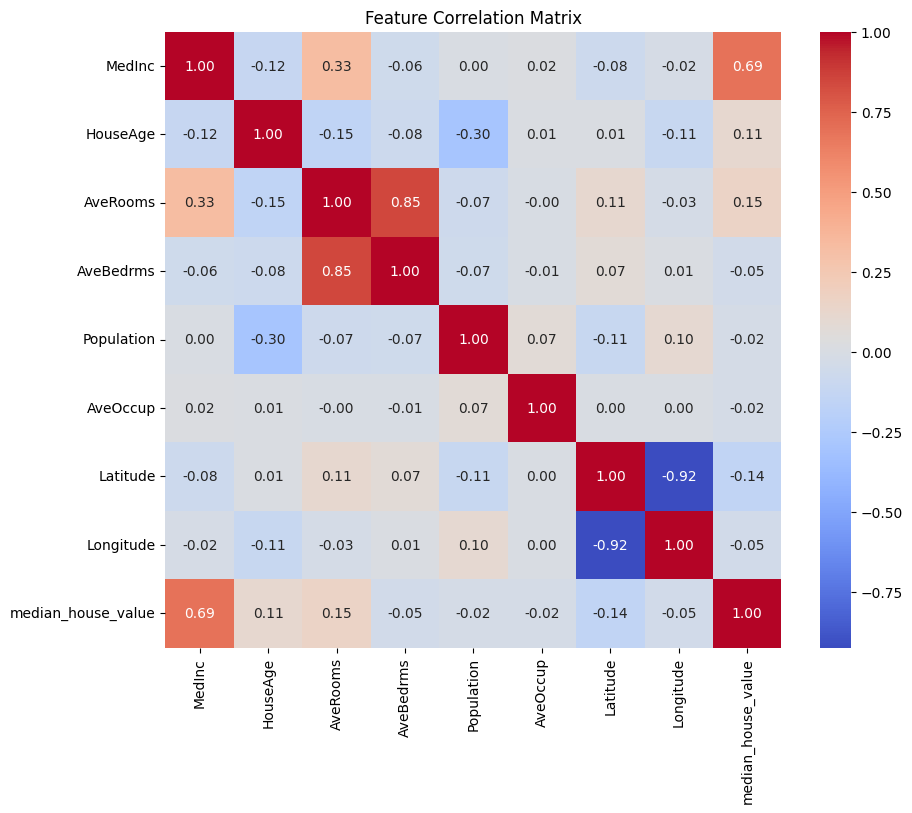

In [17]:

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix")
plt.show()


In [18]:

df1 = df.copy()
outlier_count= {}

for col in df1.select_dtypes(include=[np.number]).columns:

    print(f"Column: {col}")
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    print(f"Q1={Q1}, Q3={Q3}, IQR={IQR}")
    print(f"Lower Bound={lower}, Upper Bound={upper}")

    idx = df1[(df1[col] < lower) | (df1[col] > upper)].index
    count = len(idx)
    outlier_count[col] = count

    print(f"Outliers in {col}: {count}")

    if count > 0:
        df1 = df1.drop(index=idx)
        print(f"Removed {count} outliers.\n")
    else:
        print("No outliers.\n")

print("Original Shape:", df.shape)
print("Cleaned Shape:", df1.shape)


Column: MedInc
Q1=2.5633999999999997, Q3=4.74325, IQR=2.17985
Lower Bound=-0.7063750000000004, Upper Bound=8.013024999999999
Outliers in MedInc: 681
Removed 681 outliers.

Column: HouseAge
Q1=18.0, Q3=37.0, IQR=19.0
Lower Bound=-10.5, Upper Bound=65.5
Outliers in HouseAge: 0
No outliers.

Column: AveRooms
Q1=4.411435075737677, Q3=5.958062770562771, IQR=1.5466276948250943
Lower Bound=2.091493533500035, Upper Bound=8.278004312800412
Outliers in AveRooms: 439
Removed 439 outliers.

Column: AveBedrms
Q1=1.005952380952381, Q3=1.096774193548387, IQR=0.09082181259600608
Lower Bound=0.8697196620583718, Upper Bound=1.2330069124423961
Outliers in AveBedrms: 1116
Removed 1116 outliers.

Column: Population
Q1=836.0, Q3=1775.0, IQR=939.0
Lower Bound=-572.5, Upper Bound=3183.5
Outliers in Population: 1063
Removed 1063 outliers.

Column: AveOccup
Q1=2.4285714285714284, Q3=3.2857142857142856, IQR=0.8571428571428572
Lower Bound=1.1428571428571426, Upper Bound=4.571428571428571
Outliers in AveOccup: 528

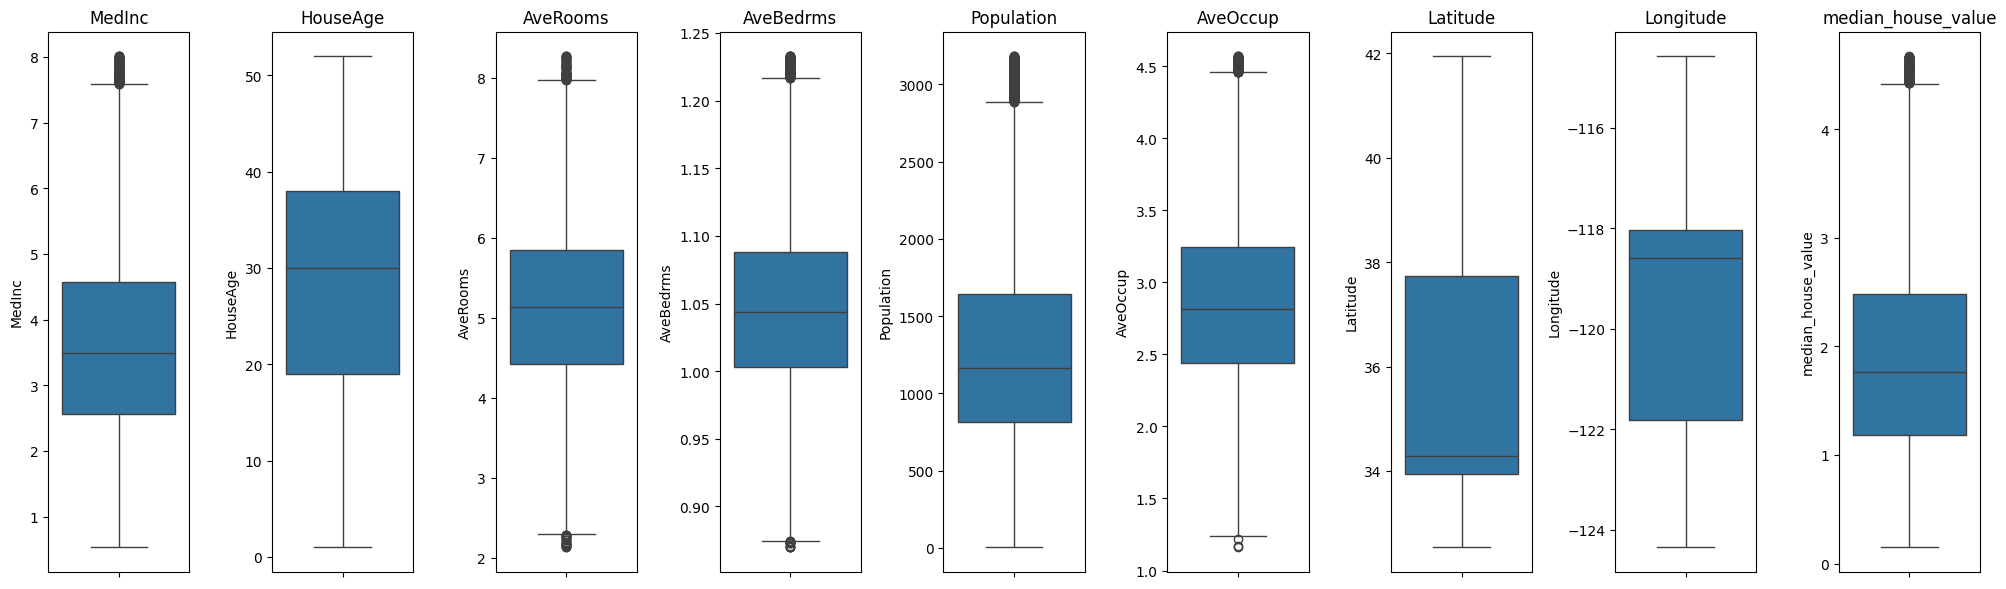

In [19]:
plt.figure(figsize=(20, 6))

for i, col in enumerate(df1.columns, 1):
    plt.subplot(1, len(df1.columns), i)
    sns.boxplot(y=df1[col])
    plt.title(col)

plt.tight_layout()
plt.show()

In [20]:
X = df.drop(columns=["median_house_value"])
y = df["median_house_value"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (16512, 8) Test shape: (4128, 8)


In [21]:
import time
from sklearn.pipeline import Pipeline
def print_metrics(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Metrics:")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2: {r2:.4f}")
    print("-" * 30)
    return {"Model": name, "MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}


models = {
    "LinearRegression": Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())]),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "SVR": Pipeline([("scaler", StandardScaler()), ("svr", SVR())])
}

results = []
for name, model in models.items():
    t0 = time.time()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    res = print_metrics(y_test, preds, name)
    res["fit_time_sec"] = time.time() - t0
    results.append(res)

results_df = pd.DataFrame(results).sort_values("R2", ascending=False)
results_df

LinearRegression Metrics:
  MAE: 0.5332
  MSE: 0.5559
  RMSE: 0.7456
  R2: 0.5758
------------------------------
DecisionTree Metrics:
  MAE: 0.4547
  MSE: 0.4952
  RMSE: 0.7037
  R2: 0.6221
------------------------------
RandomForest Metrics:
  MAE: 0.3275
  MSE: 0.2554
  RMSE: 0.5053
  R2: 0.8051
------------------------------
GradientBoosting Metrics:
  MAE: 0.3716
  MSE: 0.2940
  RMSE: 0.5422
  R2: 0.7756
------------------------------
SVR Metrics:
  MAE: 0.3986
  MSE: 0.3570
  RMSE: 0.5975
  R2: 0.7276
------------------------------


,Model,MAE,MSE,RMSE,R2,fit_time_sec
2,RandomForest,0.327543,0.255368,0.505340,0.805123,9.954303
3,GradientBoosting,0.371643,0.293997,0.542215,0.775645,4.322642
4,SVR,0.398599,0.357004,0.597498,0.727563,9.443123
1,DecisionTree,0.454679,0.495235,0.703729,0.622076,0.237242
0,LinearRegression,0.533200,0.555892,0.745581,0.575788,0.013055


In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
for name, model in models.items():

    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="r2", n_jobs=-1)
    cv_results.append({"model": name, "cv_r2_mean": scores.mean(), "cv_r2_std": scores.std()})
    print(f"{name} CV R2 mean: {scores.mean():.4f} ± {scores.std():.4f}")

cv_df = pd.DataFrame(cv_results).sort_values("cv_r2_mean", ascending=False)
cv_df


LinearRegression CV R2 mean: 0.6115 ± 0.0124
DecisionTree CV R2 mean: 0.5973 ± 0.0240
RandomForest CV R2 mean: 0.8045 ± 0.0061
GradientBoosting CV R2 mean: 0.7881 ± 0.0068
SVR CV R2 mean: 0.7365 ± 0.0103


,model,cv_r2_mean,cv_r2_std
2,RandomForest,0.804550,0.006109
3,GradientBoosting,0.788089,0.006788
4,SVR,0.736538,0.010297
0,LinearRegression,0.611457,0.012359
1,DecisionTree,0.597252,0.023962


In [23]:
param_grids = {
    "DecisionTree": {
        "max_depth": [6, 8, 10, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "RandomForest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20, None],
        "max_features": ["auto", "sqrt"]
    },
    "GradientBoosting": {
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 5]
    },
    "SVR": {
        "svr__C": [0.1, 1, 10],
        "svr__gamma": ["scale", "auto"],
        "svr__epsilon": [0.1, 0.2, 0.5]
    }
}

best_params = {}
best_scores = {}

for name, model in models.items():

    if name == "LinearRegression": # Changed from "Linear Regression" to "LinearRegression" to match models dict key
        print("Linear Regression has no hyperparameters to tune via GridSearchCV with these params.\n")
        continue

    grid = GridSearchCV(
        model, param_grids[name], cv=5, scoring='r2', n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_params[name] = grid.best_params_
    best_scores[name] = grid.best_score_

    print(f"{name}: Best R² = {grid.best_score_:.4f}")
    print("Best Params:", grid.best_params_, "\n")


Linear Regression has no hyperparameters to tune via GridSearchCV with these params.

DecisionTree: Best R² = 0.7101
Best Params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2} 

RandomForest: Best R² = 0.8154
Best Params: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200} 

GradientBoosting: Best R² = 0.8312
Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200} 

SVR: Best R² = 0.7616
Best Params: {'svr__C': 10, 'svr__epsilon': 0.2, 'svr__gamma': 'auto'} 



In [24]:
final_scores = {}

for name, params in best_params.items():
    model = models[name].set_params(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    r2 = r2_score(y_test, preds)
    final_scores[name] = r2

    print(name)
    print("MSE:", mean_squared_error(y_test, preds))
    print("MAE:", mean_absolute_error(y_test, preds))
    print("R²:", r2, "\n")

best_model = max(final_scores, key=final_scores.get)

print("Best Model:", best_model)
print("Best R²:", final_scores[best_model])

DecisionTree
MSE: 0.40840458615620523
MAE: 0.4311152226926481
R²: 0.6883380738855668 

RandomForest
MSE: 0.2439549463549592
MAE: 0.32742181906492274
R²: 0.8138329709229819 

GradientBoosting
MSE: 0.22430711347823123
MAE: 0.3143395438082569
R²: 0.8288266356513045 

SVR
MSE: 0.3212728987168642
MAE: 0.37962385815266
R²: 0.7548300537835579 

Best Model: GradientBoosting
Best R²: 0.8288266356513045
